In [1]:
import argparse,os,logging,psutil,time
from joblib import Parallel,delayed
from sklearn.model_selection import train_test_split, KFold
import shutil
import sys
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# %%capture
%run utils.ipynb
%run make_graph2vec_corpus.ipynb
%run train_utils_new.ipynb
%run classify_new.ipynb

/home/ipsita/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ipsita/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ipsita/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ipsita/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
base_dir = '/home/ipsita/BTP/graph2vec/tmp/for_gui/'

In [4]:
dataset_name = "mutag"
corpus_dir = "/home/ipsita/BTP/graph2vec/data/kdd_datasets/"+dataset_name
output_dir = base_dir + "embeddings"
batch_size = 128
epochs = 400 ######################################
embedding_size = 512
num_negsample = 10
learning_rate = 0.3
wlk_h = 3
label_filed_name = 'Label'
class_labels_fname = '/home/ipsita/BTP/graph2vec/data/kdd_datasets/'+dataset_name+'.Labels'
win_size = 2
concat_flag = 0  #### Add or concat

wl_extn = 'g2v'+str(wlk_h) 

assert os.path.exists(corpus_dir), "File {} does not exist".format(corpus_dir)
assert os.path.exists(output_dir), "Dir {} does not exist".format(output_dir)

In [5]:
graph_files = get_files(dirname=corpus_dir, extn='.gexf', max_files=0)
logging.info('Loaded {} graph file names form {}'.format(len(graph_files),corpus_dir))
graph_files[:5]

INFO:root:Loaded 188 graph file names form /home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag


['/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/0.gexf',
 '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/1.gexf',
 '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/10.gexf',
 '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/100.gexf',
 '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/101.gexf']

In [6]:
t0 = time.time()
wlk_relabel_and_dump_memory_version(graph_files, max_h=wlk_h, node_label_attr_name=label_filed_name)
logging.info('dumped sg2vec sentences in {} sec.'.format(time.time() - t0))

INFO:root:dumped sg2vec sentences in 0.8912167549133301 sec.


loaded all graphs in 0.74 sec
initial relabeling done in 0.03 sec
WL iteration 1 done in 0.03 sec.
num of WL rooted subgraphs in iter 1 is 33
WL iteration 2 done in 0.03 sec.
num of WL rooted subgraphs in iter 2 is 174
WL iteration 3 done in 0.03 sec.
num of WL rooted subgraphs in iter 3 is 572
dumped sg2vec sentences in 0.03


In [7]:
X = np.array([g+"."+wl_extn for g in graph_files])
graph_to_class_label_map = {l.split()[0].split('.')[0]: int(l.split()[1].strip()) for l in open (class_labels_fname)}
Y = np.array([graph_to_class_label_map[os.path.basename(g).split('.')[0]] for g in X])

In [8]:
X[:5]

array(['/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/0.gexf.g2v3',
       '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/1.gexf.g2v3',
       '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/10.gexf.g2v3',
       '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/100.gexf.g2v3',
       '/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/101.gexf.g2v3'],
      dtype='<U64')

In [9]:
# def split_data():
    
#     Y = list(range(0, len(graph_files)))
    
#     Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.20)

#     print('Xtrain shape', np.shape(Xtrain))
#     labels = [graph_to_class_label_map[os.path.basename(g).split('.')[0]] for g in Xtrain]
#     Ytrain = np.array(labels)
#     print('Ytrain shape', np.shape(Ytrain))

#     print('Xtest shape', np.shape(Xtest))
#     labels = [graph_to_class_label_map[os.path.basename(g).split('.')[0]] for g in Xtest] 
#     Ytest = np.array(labels)
#     print('Ytest shape', np.shape(Ytest))
    
#     return Xtrain, Xtest, Ytrain, Ytest

In [10]:
# def preprocess(X):
#     Xnew = []
#     for x in X:
#         d = x.split('/')[-2]
#         g = x.split('/')[-1]
#         Xnew.append(base_dir + d + '/' + g)
#     return np.array(Xnew)

## No need to train again

INFO:root:Initializing SKIPGRAM...
INFO:root:number of graphs: 188
INFO:root:subgraph vocabulary size: 787
INFO:root:total number of subgraphs to be trained: 13485


number of graphs: 188
subgraph vocabulary size: 787
total number of subgraphs to be trained: 13485
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Shape final embed [128, 1024]


INFO:root:#########################   Epoch: 0 :  19.866548, 1.20 sec.  #####################
INFO:root:#########################   Epoch: 1 :  11.400806, 0.41 sec.  #####################
INFO:root:#########################   Epoch: 2 :  8.326573, 0.42 sec.  #####################
INFO:root:#########################   Epoch: 3 :  4.972954, 0.41 sec.  #####################
INFO:root:#########################   Epoch: 4 :  4.589118, 0.43 sec.  #####################
INFO:root:#########################   Epoch: 5 :  3.484136, 0.43 sec.  #####################
INFO:root:#########################   Epoch: 6 :  2.838482, 0.40 sec.  #####################
INFO:root:#########################   Epoch: 7 :  2.874115, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 8 :  2.459714, 0.53 sec.  #####################
INFO:root:#########################   Epoch: 9 :  2.069195, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 10 :  1.982019, 0.42 se

INFO:root:#########################   Epoch: 88 :  0.857127, 0.47 sec.  #####################
INFO:root:#########################   Epoch: 89 :  0.842676, 0.40 sec.  #####################
INFO:root:#########################   Epoch: 90 :  0.848109, 0.37 sec.  #####################
INFO:root:#########################   Epoch: 91 :  0.849041, 0.44 sec.  #####################
INFO:root:#########################   Epoch: 92 :  0.840902, 0.48 sec.  #####################
INFO:root:#########################   Epoch: 93 :  0.822442, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 94 :  0.849113, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 95 :  0.853752, 0.43 sec.  #####################
INFO:root:#########################   Epoch: 96 :  0.820590, 0.40 sec.  #####################
INFO:root:#########################   Epoch: 97 :  0.811097, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 98 :  0.803497,

INFO:root:#########################   Epoch: 175 :  0.747722, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 176 :  0.764087, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 177 :  0.759554, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 178 :  0.768099, 0.40 sec.  #####################
INFO:root:#########################   Epoch: 179 :  0.746487, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 180 :  0.760633, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 181 :  0.760719, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 182 :  0.770542, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 183 :  0.767260, 0.42 sec.  #####################
INFO:root:#########################   Epoch: 184 :  0.762660, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 185 :

INFO:root:#########################   Epoch: 262 :  0.738744, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 263 :  0.743357, 0.40 sec.  #####################
INFO:root:#########################   Epoch: 264 :  0.727169, 0.56 sec.  #####################
INFO:root:#########################   Epoch: 265 :  0.724022, 0.47 sec.  #####################
INFO:root:#########################   Epoch: 266 :  0.720533, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 267 :  0.714879, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 268 :  0.710088, 0.48 sec.  #####################
INFO:root:#########################   Epoch: 269 :  0.732722, 0.45 sec.  #####################
INFO:root:#########################   Epoch: 270 :  0.731192, 0.45 sec.  #####################
INFO:root:#########################   Epoch: 271 :  0.734389, 0.47 sec.  #####################
INFO:root:#########################   Epoch: 272 :

INFO:root:#########################   Epoch: 349 :  0.715135, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 350 :  0.708463, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 351 :  0.688365, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 352 :  0.703449, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 353 :  0.712745, 0.38 sec.  #####################
INFO:root:#########################   Epoch: 354 :  0.704625, 0.40 sec.  #####################
INFO:root:#########################   Epoch: 355 :  0.700602, 0.41 sec.  #####################
INFO:root:#########################   Epoch: 356 :  0.691638, 0.40 sec.  #####################
INFO:root:#########################   Epoch: 357 :  0.714694, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 358 :  0.694004, 0.39 sec.  #####################
INFO:root:#########################   Epoch: 359 :

Model saved in path: /home/ipsita/BTP/graph2vec/tmp/for_gui/model_ckpt/1/model2.ckpt


INFO:root:Completed writing the final subgraph embeddings, pls check file: /home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/mutag_dims_512_epochs_400_lr_0.3_subgraph_embedding.txt for the same


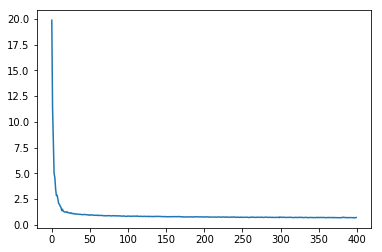

In [11]:
all_acc = []
for i in range(0, 1):     # change to 1 to 10
    
    #i = 1 #########################################################
    #Xtrain, Xtest, Ytrain, Ytest = split_data()
    path   = base_dir + "splits_"+ dataset_name +"/"
    Xtrain = np.load(path + str(i+1) + '/x_train.npy')
    Xtest  = np.load(path + str(i+1) + '/x_test.npy')
    Ytrain = np.load(path + str(i+1) + '/y_train.npy')
    Ytest  = np.load(path + str(i+1) + '/y_test.npy')

    cpath = base_dir + 'model_ckpt/1'
    os.mkdir(cpath)

    ### THIS IS TRAINING ON THE WHOLE DATA ###
    embedding_fname, subgraph_embedding_fname = train_skipgram(corpus_dir, wl_extn, learning_rate, win_size, concat_flag, 
                                         cpath, X, embedding_size, num_negsample, epochs, batch_size, output_dir)
    
#     final_a = perform_classification_final_new(Xtrain, Ytrain, Xtest, Ytest, embedding_fname)
#     all_acc.append(final_a)

In [15]:
subgraph_embedding_fname = '/home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/mutag_dims_512_epochs_400_lr_0.3_subgraph_embedding.txt'

## Graph vectors from subgraph addition

In [16]:
graph_embeddings = np.zeros((len(X), embedding_size))
subgraphs = []

for fname in X:
    tmp = [l.split()[0] for l in open(fname).readlines()]
    subgraphs.append(np.unique(tmp))
len(subgraphs)

188

In [17]:
with open(subgraph_embedding_fname, 'r') as fh:
    subgraph_embedding_dict = json.load(fh)

In [18]:
for i in range(0, len(X)):
    for s in subgraphs[i]:
        graph_embeddings[i,:] += subgraph_embedding_dict[s]

In [19]:
## TO NORMALIZE ###
norm = np.sqrt(np.mean(np.square(graph_embeddings)))
graph_embeddings = graph_embeddings/norm

In [20]:
final_embedding_fname = '/home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/final_graph_embedding.txt'

In [32]:
dict_to_save = {}

for i in range(0, len(X)):
    graph_fname = X[i]
    graph_embed = graph_embeddings[i, :].tolist()
    dict_to_save[graph_fname] = graph_embed
    
with open(final_embedding_fname, 'w') as fh:
    json.dump(dict_to_save,fh,indent=4)

In [15]:
acc_list_new = []
acc_list_old = []

In [21]:
embedding_fname = "/home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/mutag_dims_512_epochs_400_lr_0.3_embeddings.txt"

In [77]:
for i in range(0, 10):
    Xtrain = np.load(path + str(i+1) + '/x_train.npy')
    Xtest  = np.load(path + str(i+1) + '/x_test.npy')
    Ytrain = np.load(path + str(i+1) + '/y_train.npy')
    Ytest  = np.load(path + str(i+1) + '/y_test.npy')

    acc = perform_classification_final_new(Xtrain, Ytrain, Xtest, Ytest, embedding_fname)
    acc_list_old.append(acc)
    
    acc = perform_classification_final_new(Xtrain, Ytrain, Xtest, Ytest, final_embedding_fname)
    acc_list_new.append(acc)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.8421052631578947
INFO:root:             precision    recall  f1-score   support

         -1       0.67      0.80      0.73        10
          1       0.92      0.86      0.89        28

avg / total       0.86      0.84      0.85        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.1s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.9210526315789473
INFO:root:             precision    recall  f1-score   support

         -1       0.77      1.00      0.87        10
          1       1.00      0.89      0.94        28

avg / total       0.94      0.92      0.92        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.7894736842105263
INFO:root:             precision    recall  f1-score   support

         -1       0.67      0.67      0.67        12
          1       0.85      0.85      0.85        26

avg / total       0.79      0.79      0.79        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.3s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.8421052631578947
INFO:root:             precision    recall  f1-score   support

         -1       0.75      0.75      0.75        12
          1       0.88      0.88      0.88        26

avg / total       0.84      0.84      0.84        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.7894736842105263
INFO:root:             precision    recall  f1-score   support

         -1       0.83      0.62      0.71        16
          1       0.77      0.91      0.83        22

avg / total       0.80      0.79      0.78        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.8s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.7105263157894737
INFO:root:             precision    recall  f1-score   support

         -1       0.73      0.50      0.59        16
          1       0.70      0.86      0.78        22

avg / total       0.71      0.71      0.70        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.7631578947368421
INFO:root:             precision    recall  f1-score   support

         -1       0.53      0.80      0.64        10
          1       0.91      0.75      0.82        28

avg / total       0.81      0.76      0.78        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.9s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.8157894736842105
INFO:root:             precision    recall  f1-score   support

         -1       0.60      0.90      0.72        10
          1       0.96      0.79      0.86        28

avg / total       0.86      0.82      0.83        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.7894736842105263
INFO:root:             precision    recall  f1-score   support

         -1       0.71      0.71      0.71        14
          1       0.83      0.83      0.83        24

avg / total       0.79      0.79      0.79        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.8s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.868421052631579
INFO:root:             precision    recall  f1-score   support

         -1       0.74      1.00      0.85        14
          1       1.00      0.79      0.88        24

avg / total       0.90      0.87      0.87        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.7368421052631579
INFO:root:             precision    recall  f1-score   support

         -1       0.71      0.62      0.67        16
          1       0.75      0.82      0.78        22

avg / total       0.73      0.74      0.73        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.0s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.9210526315789473
INFO:root:             precision    recall  f1-score   support

         -1       0.93      0.88      0.90        16
          1       0.91      0.95      0.93        22

avg / total       0.92      0.92      0.92        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.6s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.868421052631579
INFO:root:             precision    recall  f1-score   support

         -1       0.80      0.94      0.86        17
          1       0.94      0.81      0.87        21

avg / total       0.88      0.87      0.87        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.8s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.8157894736842105
INFO:root:             precision    recall  f1-score   support

         -1       0.81      0.76      0.79        17
          1       0.82      0.86      0.84        21

avg / total       0.82      0.82      0.82        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.5s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.9473684210526315
INFO:root:             precision    recall  f1-score   support

         -1       0.88      1.00      0.93        14
          1       1.00      0.92      0.96        24

avg / total       0.95      0.95      0.95        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.9s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.868421052631579
INFO:root:             precision    recall  f1-score   support

         -1       0.80      0.86      0.83        14
          1       0.91      0.88      0.89        24

avg / total       0.87      0.87      0.87        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.5s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.8947368421052632
INFO:root:             precision    recall  f1-score   support

         -1       0.83      0.83      0.83        12
          1       0.92      0.92      0.92        26

avg / total       0.89      0.89      0.89        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.9s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.8157894736842105
INFO:root:             precision    recall  f1-score   support

         -1       1.00      0.42      0.59        12
          1       0.79      1.00      0.88        26

avg / total       0.85      0.82      0.79        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.7631578947368421
INFO:root:             precision    recall  f1-score   support

         -1       0.71      0.67      0.69        15
          1       0.79      0.83      0.81        23

avg / total       0.76      0.76      0.76        38



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    3.9s finished
INFO:root:best classifier model's hyperparamters
INFO:root:Linear SVM accuracy: 0.8947368421052632
INFO:root:             precision    recall  f1-score   support

         -1       0.87      0.87      0.87        15
          1       0.91      0.91      0.91        23

avg / total       0.89      0.89      0.89        38



In [78]:
print(np.mean(acc_list_old))
acc_list_old

0.8184210526315789


[0.8421052631578947,
 0.7894736842105263,
 0.7894736842105263,
 0.7631578947368421,
 0.7894736842105263,
 0.7368421052631579,
 0.868421052631579,
 0.9473684210526315,
 0.8947368421052632,
 0.7631578947368421]

In [79]:
print(np.mean(acc_list_new))
acc_list_new

0.8473684210526317


[0.9210526315789473,
 0.8421052631578947,
 0.7105263157894737,
 0.8157894736842105,
 0.868421052631579,
 0.9210526315789473,
 0.8157894736842105,
 0.868421052631579,
 0.8157894736842105,
 0.8947368421052632]

## See graph subgraph dot product

In [22]:
belong_list = []
not_belong_list = []

with open(subgraph_embedding_fname, 'r') as fh:
    subgraph_embedding_dict = json.load(fh)

with open(final_embedding_fname, 'r') as fh:
    graph_embedding_dict = json.load(fh)

In [23]:
subgraphs_list = list(subgraph_embedding_dict.keys())

In [24]:
for g in X:
    
    b_list  = []
    nb_list = []
    graph_vector = graph_embedding_dict[g]
    
    dot_values = []
    for s in subgraph_embedding_dict.keys():
        pval = np.sum( np.dot(graph_vector, subgraph_embedding_dict[s]))
        dot_values.append(pval)
    
    norm = np.sqrt(np.mean(np.square(dot_values))) ############### FOR NOW DOT PRODUCT ##############
    dot_values = dot_values/norm
    
    # print(dot_values) ##
    
    for d in range(0, len(dot_values)):
        if dot_values[d] >= 0.8:
            b_list.append(subgraphs_list[d])
        else:
            nb_list.append(subgraphs_list[d])

    belong_list.append(b_list)
    not_belong_list.append(nb_list)
    

In [25]:
### check similarity measure ###

In [85]:
graph_matrix    = np.array(graph_embedding_dict[X[0]])
graph_matrix = graph_matrix.reshape((1, embedding_size))
subgraph_matrix = np.zeros((len(subgraph_embedding_dict), embedding_size))

i = 0
for k in subgraph_embedding_dict.keys():
    subgraph_matrix[i,:] = subgraph_embedding_dict[k]
    i = i + 1

print(np.shape(graph_matrix), np.shape(subgraph_matrix))

(1, 512) (787, 512)


In [86]:
result = cosine_similarity(subgraph_matrix, graph_matrix)
result = np.reshape( result, (np.shape(result)[0]))

In [91]:
keys_list = list(subgraph_embedding_dict.keys())
yes_count = 0
no_count = 0

for r in range(0, len(result)):
    if result[r] > 0.5:
#         print(keys_list[r])
        if keys_list[r] in subgraphs[0]:
            yes_count += 1
        else:
            no_count += 1
    else:
        if keys_list[r] in subgraphs[0]:
            print(result[r])
print("YES = ", yes_count, " NO = ", no_count)

0.4397153586077825
0.0398202106657068
0.4072566566448389
0.3111625849152679
0.03430494292807259
0.42728490278533515
0.16138538994936472
0.41952477295448687
0.4573378857033087
0.4629876355518644
0.45284808446850155
0.3779710603148947
0.36881323375585107
0.12786537633882591
0.40143773569248375
0.15654341360240343
0.46117782654816813
0.28085268603850816
YES =  17  NO =  474


In [130]:
index_list = []
for k in range(0, len(keys_list)):
    if keys_list[k] in subgraphs[0]:
        index_list.append(k)

In [134]:
result[index_list]

array([0.43971536, 0.03982021, 0.51074383, 0.40725666, 0.31116258,
       0.60670351, 0.03430494, 0.4272849 , 0.50841029, 0.59770698,
       0.66055444, 0.52444341, 0.50506275, 0.16138539, 0.41952477,
       0.67356537, 0.45733789, 0.46298764, 0.63286088, 0.45284808,
       0.60205981, 0.59709866, 0.59575443, 0.58648882, 0.5881471 ,
       0.61579037, 0.37797106, 0.36881323, 0.12786538, 0.58497391,
       0.66445056, 0.40143774, 0.15654341, 0.46117783, 0.28085269])

In [119]:
keys_list[110]

'3+77'

In [120]:
result[110]

0.33923165251420345

In [ ]:
0.52

In [37]:
## hard code and see dot products of matching subgraphs and graphs

In [56]:
np.unique(subgraphs[100])

array(['0+1', '0+2', '0+3', '1+1', '1+2', '1+3', '1+4', '1+5', '2+1',
       '2+10', '2+11', '2+12', '2+2', '2+3', '2+8', '2+9', '3+1', '3+127',
       '3+128', '3+17', '3+2', '3+26', '3+3', '3+4', '3+43', '3+99'],
      dtype='<U5')

In [39]:
np.unique(subgraphs[0])

array(['0+1', '0+2', '0+3', '1+1', '1+2', '1+3', '1+4', '1+5', '2+1',
       '2+10', '2+2', '2+3', '2+4', '2+5', '2+6', '2+7', '2+8', '2+9',
       '3+1', '3+10', '3+11', '3+12', '3+13', '3+14', '3+15', '3+16',
       '3+17', '3+2', '3+3', '3+4', '3+5', '3+6', '3+7', '3+8', '3+9'],
      dtype='<U4')

In [40]:
gvec = graph_embedding_dict[X[1]]

In [41]:
svec = subgraph_embedding_dict['0+1']
np.sum(np.dot(gvec, svec))

256.0428542574414

In [42]:
svec = subgraph_embedding_dict['1+1']
np.sum(np.dot(gvec, svec))

30.07121543468609

In [43]:
svec = subgraph_embedding_dict['2+1']
np.sum(np.dot(gvec, svec))

238.4858146037863

In [44]:
svec = subgraph_embedding_dict['3+1']
np.sum(np.dot(gvec, svec))

189.91544991493876

In [45]:
svec = subgraph_embedding_dict['3+9']
np.sum(np.dot(gvec, svec))

209.48260295018054

In [57]:
svec = subgraph_embedding_dict['3+99']
np.sum(np.dot(gvec, svec))

276.2175996251453

In [47]:
svec = subgraph_embedding_dict['2+14']
np.sum(np.dot(gvec, svec))

296.0614599481729

## lets see for a graph 

In [26]:
true_positives = []
false_positives = []

true_negatives = []
false_negatives = []

true_positives_subgraphs = []
false_positives_subgraphs = []

true_negatives_subgraphs = []
false_negatives_subgraphs = []

In [27]:
for gnum in range(0, len(X)):
    
    tp = []
    fp = []
    tn = []
    fn = []
    
    for s in belong_list[gnum]:
        if s in subgraphs[gnum]:
            tp.append(s)
        else:
            fp.append(s)

    for s in not_belong_list[gnum]:
        if s in subgraphs[gnum]:
            fn.append(s)
        else:
            tn.append(s)
    
    true_positives.append(len(tp))
    false_positives.append(len(fp))
    true_negatives.append(len(tn))
    false_negatives.append(len(fn))
    
    true_positives_subgraphs.append(tp)
    false_positives_subgraphs.append(fp)
    true_negatives_subgraphs.append(tn)
    false_negatives_subgraphs.append(fn)    

In [23]:
np.mean(true_positives)

15.037234042553191

In [24]:
np.mean(false_positives)

497.72340425531917

In [29]:
np.mean(false_negatives)

16.835106382978722

In [30]:
np.mean(true_negatives)

257.40425531914894

In [31]:
true_positives = np.array(true_positives)
true_negatives = np.array(true_negatives)
false_positives = np.array(false_positives)
false_negatives = np.array(false_negatives)

In [32]:
precission = (true_positives)/(true_positives + false_positives)

In [33]:
recall = (true_positives)/(true_positives + false_negatives)

In [34]:
np.mean(precission)

0.029354941044771

In [35]:
np.mean(recall)

0.4685092607507094

## For each subgraph store number of times its predicted correct and when wrong

In [42]:
correct_pred = []
wrong_pred   = []

In [43]:
for s in subgraphs_list:
    counter1 = 0
    counter2 = 0
    
    for g in range(0, len(X)):
        if s in true_positives_subgraphs[g]:
            counter1 += 1
        elif s in true_negatives_subgraphs[g]:
            counter1 += 1
        elif s in false_positives_subgraphs[g]:
            counter2 += 1
        elif s in false_negatives_subgraphs[g]:
            counter2 += 1
    
    correct_pred.append(counter1)
    wrong_pred.append(counter2)

In [44]:
correct_pred

[122,
 1,
 134,
 148,
 39,
 140,
 39,
 85,
 134,
 172,
 117,
 167,
 157,
 2,
 93,
 34,
 45,
 49,
 118,
 126,
 35,
 90,
 16,
 45,
 146,
 24,
 132,
 0,
 0,
 185,
 74,
 0,
 0,
 31,
 3,
 136,
 167,
 122,
 62,
 91,
 175,
 3,
 21,
 187,
 20,
 89,
 156,
 4,
 4,
 163,
 17,
 4,
 98,
 142,
 172,
 36,
 9,
 43,
 166,
 11,
 58,
 102,
 161,
 154,
 187,
 10,
 42,
 187,
 124,
 41,
 45,
 15,
 11,
 183,
 105,
 180,
 35,
 13,
 171,
 22,
 184,
 34,
 6,
 18,
 11,
 184,
 20,
 152,
 5,
 2,
 173,
 6,
 170,
 181,
 71,
 74,
 7,
 188,
 3,
 171,
 186,
 180,
 34,
 23,
 187,
 11,
 186,
 181,
 185,
 5,
 185,
 25,
 45,
 184,
 25,
 5,
 180,
 39,
 7,
 2,
 164,
 9,
 2,
 1,
 186,
 110,
 175,
 98,
 155,
 186,
 182,
 160,
 8,
 166,
 10,
 68,
 12,
 173,
 4,
 142,
 1,
 2,
 1,
 1,
 126,
 1,
 1,
 1,
 173,
 2,
 13,
 2,
 2,
 186,
 2,
 2,
 2,
 1,
 5,
 1,
 184,
 147,
 3,
 6,
 186,
 142,
 1,
 187,
 2,
 53,
 2,
 2,
 183,
 2,
 2,
 39,
 11,
 7,
 178,
 95,
 63,
 187,
 183,
 5,
 26,
 5,
 3,
 1,
 90,
 7,
 183,
 68,
 172,
 15,
 23,
 4,
 4

In [45]:
wrong_pred

[66,
 187,
 54,
 40,
 149,
 48,
 149,
 103,
 54,
 16,
 71,
 21,
 31,
 186,
 95,
 154,
 143,
 139,
 70,
 62,
 153,
 98,
 172,
 143,
 42,
 164,
 56,
 188,
 188,
 3,
 114,
 188,
 188,
 157,
 185,
 52,
 21,
 66,
 126,
 97,
 13,
 185,
 167,
 1,
 168,
 99,
 32,
 184,
 184,
 25,
 171,
 184,
 90,
 46,
 16,
 152,
 179,
 145,
 22,
 177,
 130,
 86,
 27,
 34,
 1,
 178,
 146,
 1,
 64,
 147,
 143,
 173,
 177,
 5,
 83,
 8,
 153,
 175,
 17,
 166,
 4,
 154,
 182,
 170,
 177,
 4,
 168,
 36,
 183,
 186,
 15,
 182,
 18,
 7,
 117,
 114,
 181,
 0,
 185,
 17,
 2,
 8,
 154,
 165,
 1,
 177,
 2,
 7,
 3,
 183,
 3,
 163,
 143,
 4,
 163,
 183,
 8,
 149,
 181,
 186,
 24,
 179,
 186,
 187,
 2,
 78,
 13,
 90,
 33,
 2,
 6,
 28,
 180,
 22,
 178,
 120,
 176,
 15,
 184,
 46,
 187,
 186,
 187,
 187,
 62,
 187,
 187,
 187,
 15,
 186,
 175,
 186,
 186,
 2,
 186,
 186,
 186,
 187,
 183,
 187,
 4,
 41,
 185,
 182,
 2,
 46,
 187,
 1,
 186,
 135,
 186,
 186,
 5,
 186,
 186,
 149,
 177,
 181,
 10,
 93,
 125,
 1,
 5,
 183,
 162,


(array([424.,  31.,  29.,  16.,  10.,  18.,  25.,  27.,  34., 173.]),
 array([  0. ,  18.8,  37.6,  56.4,  75.2,  94. , 112.8, 131.6, 150.4,
        169.2, 188. ]),
 <a list of 10 Patch objects>)

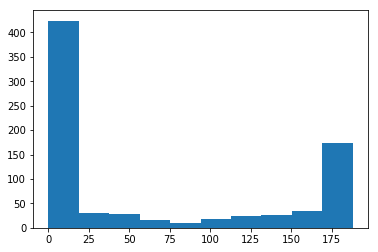

In [46]:
plt.hist(correct_pred)

(array([173.,  34.,  27.,  25.,  17.,  11.,  16.,  29.,  31., 424.]),
 array([  0. ,  18.8,  37.6,  56.4,  75.2,  94. , 112.8, 131.6, 150.4,
        169.2, 188. ]),
 <a list of 10 Patch objects>)

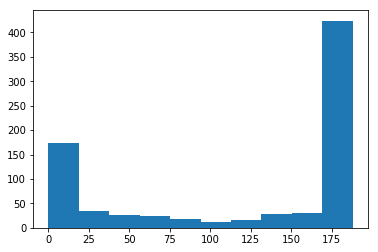

In [47]:
plt.hist(wrong_pred)

## Some PCA and tsne stuff

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit_transform(X)

# In fact there are subgraphs that are mostly predicted correct or wrong

### Now a deep learning model

Create the dataset

In [16]:
subgraph_embedding_fname = '/home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/mutag_dims_512_epochs_400_lr_0.3_subgraph_embedding.txt'

with open(subgraph_embedding_fname, 'r') as fh:
    subgraph_embedding_dict = json.load(fh)

final_embedding_fname = '/home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/final_graph_embedding.txt'

with open(final_embedding_fname, 'r') as fh:
    graph_embedding_dict = json.load(fh)

subgraphs_list = list(subgraph_embedding_dict.keys())

split the data to train and test model

In [17]:
y_dummy = np.zeros((len(X), 1))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy, test_size=0.20, random_state=40)

In [19]:
print(len(X_train), len(X_test))

150 38


In [20]:
train_data1 = []
for gnum in range(0, len(X_train)):
    gvec = graph_embedding_dict[X_train[gnum]]
    
    for s in subgraphs[gnum]:
        svec = subgraph_embedding_dict[s] 
        train_data1.append(np.concatenate((gvec, svec), axis = 0))

test_data1 = []
for gnum in range(0, len(X_test)):
    gvec = graph_embedding_dict[X_test[gnum]]
    
    for s in subgraphs[gnum]:
        sevc = subgraph_embedding_dict[s]
        test_data1.append( np.concatenate((gvec, svec), axis=0))

In [21]:
print(np.shape(train_data1), np.shape(test_data1))

(4734, 1024) (1216, 1024)


In [22]:
target_data1 = np.ones((np.shape(train_data1)[0], 1))
target_test_data1 = np.ones((np.shape(test_data1)[0], 1))
print(np.shape(target_data1), np.shape(target_test_data1))

(4734, 1) (1216, 1)


In [23]:
# train data negative
train_data2 = []
test_data2  = []

for gnum in range(0, len(X_train)):
    gvec = graph_embedding_dict[X_train[gnum]]
    i = 0from sklearn.decomposition import PCA
    
    for s in subgraphs_list:
        if s not in subgraphs[gnum]:
            i = i + 1
            if i%20 == 0:
                svec = subgraph_embedding_dict[s]
                train_data2.append(np.concatenate((gvec, svec), axis = 0))

for gnum in range(0, len(X_test)):
    gvec = graph_embedding_dict[X_test[gnum]]
    i = 0
    
    for s in subgraphs_list:
        if s not in subgraphs[gnum]:
            i = i + 1
            if i%20 == 0:
                svec = subgraph_embedding_dict[s]
                test_data2.append(np.concatenate((gvec, svec), axis = 0))

print( np.shape(train_data2), np.shape(test_data2))

(5582, 1024) (1413, 1024)


In [24]:
target_data2      = np.zeros((np.shape(train_data2)[0], 1))
target_test_data2 = np.zeros((np.shape(test_data2)[0], 1))
print(np.shape(target_data2), np.shape(target_test_data2))

(5582, 1) (1413, 1)


In [25]:
train_data = np.concatenate((train_data1, train_data2), axis =0)
train_data = np.array(train_data)
target_data = np.concatenate((target_data1, target_data2), axis=0)
print(np.shape(train_data), np.shape(target_data))

(10316, 1024) (10316, 1)


In [26]:
test_data  = np.concatenate((test_data1, test_data2), axis=0)
test_data = np.array(test_data)
target_test_data = np.concatenate((target_test_data1, target_test_data2), axis=0)
print(np.shape(test_data), np.shape(target_test_data))

(2629, 1024) (2629, 1)


In [27]:
## Shuffle the data
train_data, XX, target_data, YY = train_test_split(train_data, target_data, test_size=0, random_state=40)

In [28]:
print(np.shape(train_data), np.shape(target_data))

(10316, 1024) (10316, 1)


## Definition of the model

In [23]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D

epochs = 10
batch_size = 32

Using TensorFlow backend.


In [24]:
train_data  = train_data.reshape((np.shape(train_data)[0], np.shape(train_data)[1], 1))
target_data = target_data.reshape((np.shape(target_data)[0], 1))

test_data        = test_data.reshape((np.shape(test_data)[0], np.shape(test_data)[1], 1))
target_test_data = target_test_data.reshape((np.shape(target_test_data)[0], 1))

print(np.shape(train_data), np.shape(target_data))
print(np.shape(test_data) , np.shape(target_test_data))

(10316, 1024, 1) (10316, 1)
(2629, 1024, 1) (2629, 1)


In [25]:
def conv1d(x, W):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv1d(x, W, 1, padding='SAME')
    # x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool1d(x):
    return tf.nn.max_pool1d(x, ksize=3, strides=1, padding='SAME')

# Create model
def conv_net(x, weights):

    # Convolution Layer
    conv1 = conv1d(x, weights[0])
    conv1 = maxpool1d(conv1)
    # conv1 = tf.nn.dropout(conv1, rate=0.25)

    #conv2 = conv1d(conv1, weights[1])
    #conv2 = maxpool1d(conv2)
    # conv2 = tf.nn.dropout(conv2, rate=0.25)

    #conv3 = conv1d(conv2, weights[2])
    #conv3 = maxpool1d(conv3)
    # conv3 = tf.nn.dropout(conv3, rate=0.25)

    flt = tf.keras.layers.Flatten()(conv1)
    den = tf.layers.dense(flt, 1)
    den = tf.nn.sigmoid(den)

    return den

In [26]:
graph = tf.Graph()

with graph.as_default():

    batch_inputs = tf.placeholder(tf.float32, shape=([None, 1024, 1]))
    batch_labels = tf.placeholder(tf.float32, shape=([None, 1]))

    w1 = tf.get_variable('w1',[(1024), 1, 1], 
                       initializer=tf.truncated_normal_initializer(stddev=5e-2, dtype=tf.float32),
                       dtype= tf.float32)
  
    #w2 = tf.get_variable('w2', [(1024)//2, 1, 1],
    #                   initializer=tf.truncated_normal_initializer(stddev=5e-2, dtype=tf.float32),
    #                   dtype= tf.float32)

    #w3 = tf.get_variable('w3', [(1024)//4, 1, 1],
    #                   initializer=tf.truncated_normal_initializer(stddev=5e-2, dtype=tf.float32),
    #                   dtype=tf.float32)
  

    result = conv_net(batch_inputs, [w1])
    
    # Predictions
    #pred_classes = tf.argmax(result, axis=1)
    #prediction   = tf.nn.softmax(result)
    
    loss = tf.keras.backend.binary_crossentropy(batch_labels, result)
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits (logits=result, labels=batch_labels))
    #loss = tf.cast(tf.keras.losses.MSE(result, batch_labels), tf.float32)
    # loss = tf.cast(R_squared(batch_labels, result), tf.float32)
    #r2score = R_squared(batch_labels, result)
    
    #acc = tf.metrics.accuracy(labels=batch_labels, predictions=pred_classes)
    
    learning_rate = tf.constant(0.001, dtype=tf.float32)
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
loss_values = []
acc_values  = []

with tf.Session(graph=graph) as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)

    for e in range(epochs):

        total_batch = len(train_data) // batch_size
        x_batches = np.array_split(train_data, total_batch)
        y_batches = np.array_split(target_data, total_batch)

        avg_cost = 0
        avg_acc  = 0
        for i in range(total_batch):
                batch_x, batch_y = x_batches[i], y_batches[i]
                feed_dict = {batch_inputs: batch_x, batch_labels: batch_y}
                _, c = sess.run([optimizer, loss], feed_dict=feed_dict)
                avg_cost += np.mean(c)
                #avg_acc  += np.mean(a)

        loss_values.append(avg_cost/total_batch)
        #acc_values.append(avg_acc/total_batch)
        print("Epoch:", '%04d' % (e+1), "cost = ", avg_cost/total_batch, "acc value = ",avg_acc/total_batch)  

        y_pred_test  = sess.run(result, {batch_inputs: test_data})
        y_pred_train = sess.run(result, {batch_inputs: train_data})

    #correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    #print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))

    # accuracy = tf.reduce_mean(tf.cast(y_test, tf.float32))
    # print(sess.run([test_pred], feed_dict={batch_inputs: x_test}))
    #print("Testing Loss:", sess.run(loss, feed_dict={batch_inputs: x_test, batch_labels: y_test}))

Epoch: 0001 cost =  0.5102922196343819 acc value =  0.0


### Try this but I dont think it will work

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [33]:
clf = RandomForestClassifier(max_depth=7, random_state=0)

In [34]:
clf.fit(train_data, target_data)

/home/ipsita/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
test_pred = clf.predict(test_data)
accuracy_score(target_test_data, test_pred)

0.5150247242297451

In [38]:
train_pred = clf.predict(train_data)
accuracy_score(target_data, train_pred)

0.8513958898797984

## A FC network

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, Nadam, Adamax

In [25]:
embedding_size = 1024

model = Sequential()
model.add(Dense(embedding_size, activation='relu', input_shape=(embedding_size,)))
# model.add(Dense((embedding_size//2)))#, activation='relu'))
# model.add(Dense((embedding_size//4)))#, activation='relu'))
# model.add(Dense((embedding_size//6)))#, activation='relu'))
# model.add(Dense((embedding_size//8)))#, activation='relu'))
# model.add(Dense(20))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1025      
Total params: 1,050,625
Trainable params: 1,050,625
Non-trainable params: 0
_________________________________________________________________


In [30]:
model = Sequential()
model.add(Dense(100,  input_shape=(1024,) , activation='relu'))
# model.add(Dense(64 ,activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=0.0001),
              metrics = ['accuracy'])

              #metrics=['accuracy'])#loss='binary_crossentropy',

history = model.fit(train_data, target_data,
                    validation_split=0.25,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7737 samples, validate on 2579 samples
Epoch 1/20
7737/7737 [==============================] - 1s 189us/step - loss: 0.5451 - accuracy: 0.7368 - val_loss: 0.4795 - val_accuracy: 0.7972
Epoch 2/20
7737/7737 [==============================] - 1s 99us/step - loss: 0.4517 - accuracy: 0.8100 - val_loss: 0.4442 - val_accuracy: 0.8088
Epoch 3/20
7737/7737 [==============================] - 1s 142us/step - loss: 0.4150 - accuracy: 0.8277 - val_loss: 0.4233 - val_accuracy: 0.8100
Epoch 4/20
7737/7737 [==============================] - 1s 140us/step - loss: 0.3983 - accuracy: 0.8334 - val_loss: 0.4130 - val_accuracy: 0.8119
Epoch 5/20
7737/7737 [==============================] - 1s 100us/step - loss: 0.3849 - accuracy: 0.8402 - val_loss: 0.4062 - val_accuracy: 0.8263
Epoch 6/20
7737/7737 [==============================] - 1s 99us/step - loss: 0.3769 - accuracy: 0.8434 - val_loss: 0.4007 - val_accuracy: 0.8247
Epoch 7/20
7737/7737 [==============================] - 1s 98us/step - loss: 0

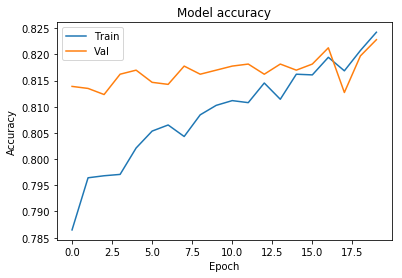

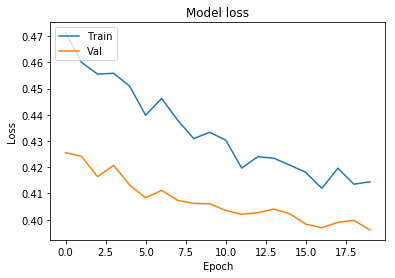

In [87]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [88]:
score1 = model.evaluate(test_data, target_test_data, verbose=1)
score2 = model.evaluate(train_data, target_data, verbose=1)

10316/10316 [==============================] - 0s 32us/step


In [89]:
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

print('Train loss:', score2[0])
print('Train accuracy:', score2[1])

Test loss: 0.5933026968185872
Test accuracy: 0.5180677175521851
Train loss: 0.3714370312687037
Train accuracy: 0.8404420614242554


In [3]:
# all_acc

In [4]:
# corpus_dir

In [16]:
# ## Display the 10th graph from this dataset
# g = nx.read_gexf(corpus_dir + '/10.gexf')
# nx.draw(g)

In [17]:
# base_dir

In [52]:
# g_new = nx.read_gexf(base_dir + 'new_graphs/1_new.gexf')
# nx.draw(g_new)

In [27]:
# g_new_path = [base_dir + '/new_graphs/12new.gexf']
# corpus_dir_new = base_dir + '/new_graphs/'

In [2]:
# wlk_relabel_and_dump_memory_version(g_new_path, max_h=wlk_h, node_label_attr_name=label_filed_name)

In [5]:
# cpath = base_dir + 'model_ckpt/1'
# embedding_fname_test = test_skipgram (corpus_dir_new, wl_extn, learning_rate, win_size, concat_flag, 
#                                      cpath, g_new_path, embedding_size, num_negsample, epochs, batch_size, output_dir)

In [6]:
# embedding_fname = '/home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/mutag_dims_1024_epochs_400_lr_0.3_embeddings.txt'

In [7]:
# embedding_fname_test

In [8]:
# with open(embedding_fname, 'r') as fh:
#         graph_embedding_dict = json.load(fh)

# with open(embedding_fname_test, 'r') as fh:
#     new_graph_embedding_dict = json.load(fh)

# print(len(graph_embedding_dict),',' ,len(new_graph_embedding_dict))

In [9]:
# dict_graphs = np.zeros((len(graph_embedding_dict), embedding_size))

# i = 0
# for k in graph_embedding_dict.keys():
#     dict_graphs[i,:] = graph_embedding_dict[k]
#     i = i + 1

In [10]:
# new_graph = np.zeros((1, embedding_size))

# i = 0
# for k in new_graph_embedding_dict.keys():
#     new_graph[i,:] = new_graph_embedding_dict[k]
#     i = i + 1

In [11]:
# from sklearn.metrics.pairwise import cosine_similarity

# result = cosine_similarity(dict_graphs, new_graph)

# print(np.shape(result))
# result = np.reshape( result, (np.shape(result)[0]))
# np.shape(result)

In [12]:
# maxvalue = -10
# maxindex = 0

# for i in range(0, len(result)):
#     if result[i] > maxvalue:
#         maxvalue = result[i]
#         maxindex = i 

In [13]:
# maxvalue

In [89]:
# maxindex = 16

In [14]:
# g_result = nx.read_gexf('/home/ipsita/BTP/graph2vec/data/kdd_datasets/ptc/'+ str(maxindex+1)+'.gexf')
# #pos = nx.drawing.layout.spring_layout(g_result)
# #nx.draw(g_result, pos)
# nx.draw(g_result)

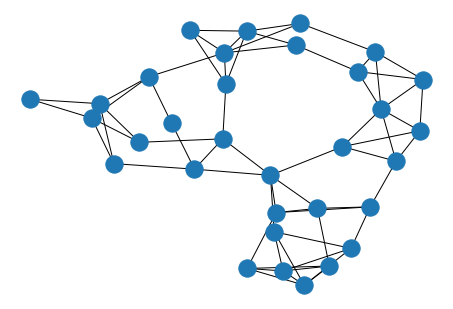

In [47]:
import networkx as nx
g = nx.read_gexf('/home/ipsita/BTP/graph2vec/data/kdd_datasets/proteins/666.gexf')
# g = nx.read_gexf('/home/ipsita/BTP/graph2vec/tmp/for_gui/new_graphs/12new.gexf')
nx.draw(g, pos = nx.nx_pydot.graphviz_layout(g))

# GUI PART

In [8]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [9]:
fu = widgets.FileUpload(
    accept='.gexf',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False  # True to accept multiple files upload else False
)


In [10]:
#%matplotlib notebook
%matplotlib qt
plt.ion()

In [11]:
btn = widgets.Button(description='Display')
#display(btn)

def btn_eventhandler(obj):
    
    fig = plt.figure(num=1)
    plt.clf()
    x = list(fu.value.keys())[0]
    bin_data = fu.value[x]['content']
    datastr= str(bin_data,'utf-8')
    with open(base_dir+"saved_graphs/1.gexf", "w") as fp:
        fp.write(datastr)
        
    g_result = nx.read_gexf(base_dir+"saved_graphs/1.gexf")
    nx.draw(g_result, pos = nx.nx_pydot.graphviz_layout(g_result))
    #nx.draw(g_result)
    fig.canvas.draw()
    

btn.on_click(btn_eventhandler)

In [19]:
btn_run = widgets.Button(description='Run !', button_style='info')
#display(btn_run)

def btn_run_eventhandler(obj):
    
    g_new_path = [base_dir + '/saved_graphs/1.gexf']
    corpus_dir_new = base_dir + '/saved_graphs/'
    
    wlk_relabel_and_dump_memory_version(g_new_path, max_h=wlk_h, node_label_attr_name=label_filed_name)
    
    cpath = base_dir + 'model_ckpt/1'
    epochs_infer = 100
    embedding_fname_test = test_skipgram (corpus_dir_new, wl_extn, learning_rate, win_size, concat_flag, 
                                     cpath, g_new_path, embedding_size, num_negsample, epochs_infer, batch_size, output_dir)

    embedding_fname = '/home/ipsita/BTP/graph2vec/tmp/for_gui/embeddings/'+dataset_name+'_dims_1024_epochs_400_lr_0.3_embeddings.txt'
    with open(embedding_fname, 'r') as fh:
        graph_embedding_dict = json.load(fh)

    with open(embedding_fname_test, 'r') as fh:
        new_graph_embedding_dict = json.load(fh)

    #print(len(graph_embedding_dict),',' ,len(new_graph_embedding_dict))
    
    dict_graphs = np.zeros((len(graph_embedding_dict), embedding_size))

    i = 0
    for k in graph_embedding_dict.keys():
        dict_graphs[i,:] = graph_embedding_dict[k]
        i = i + 1
    
    new_graph = np.zeros((1, embedding_size))

    i = 0
    for k in new_graph_embedding_dict.keys():
        new_graph[i,:] = new_graph_embedding_dict[k]
        i = i + 1
    
    result = cosine_similarity(dict_graphs, new_graph)
    result = np.reshape( result, (np.shape(result)[0]))
    
    maxvalue = -10
    maxindex = 0

    for i in range(0, len(result)):
        if result[i] > maxvalue:
            maxvalue = result[i]
            maxindex = i 
    
    print("MAXINDEX = ", maxindex+1)
    g_result = nx.read_gexf('/home/ipsita/BTP/graph2vec/data/kdd_datasets/'+dataset_name+'/'+ str(maxindex+1)+'.gexf')
    
    #Plotting part
    fig = plt.figure(num=2)
    plt.clf()
    nx.draw(g_result, pos = nx.nx_pydot.graphviz_layout(g_result))
    fig.canvas.draw()
    
    ## delete the saved graph
    os.remove(embedding_fname_test)
    os.remove(base_dir+"saved_graphs/1.gexf")
    os.remove(base_dir+"saved_graphs/1.gexf.g2v3")
    
btn_run.on_click(btn_run_eventhandler)

In [13]:
tab1 = widgets.VBox([fu, btn])

In [16]:
tab = widgets.Tab([tab1, btn_run])
tab.set_title(0, 'File Upload')
tab.set_title(1, 'Run')
#display(tab)

In [20]:
# gg = nx.read_gexf('/home/ipsita/BTP/graph2vec/data/kdd_datasets/mutag/57.gexf')
# #nx.draw(gg, pos = nx.nx_pydot.graphviz_layout(g_result))
# nx.draw(gg)